Name:  **Your name here**  
UID:  **Your student ID num here**

# Homework 2:  More Linear Algebra 

In [1]:
# Setup the environment - do not modify this cell, but run it before anything else
import numpy as np
from scipy.signal import convolve2d
from scipy.linalg import hilbert
from numpy.random import randn, normal
from numpy.linalg import norm, inv
from numpy.fft import fft2, ifft2
import urllib
import matplotlib.pyplot as plt
np.random.seed(0)

## Problem 1 - condition number
Run the following code.  

In [2]:
# Do not modify this block!
# Create a linear system Ax=b
n=8
A = hilbert(n)      # construct an n by n matrix
x = randn(n,1)      # construct n by 1 signal 
b = A@x             # Note that '@' is matrix multiplication in python, while '*' denotes entry-wise multiplication

# Solve the system to recover x
x_recovered = inv(A)@b 
print('Recovery error (clean) = %0.3g'%norm(x_recovered-x))

# Add some noise
b_noise = b+randn(n,1)*0.0000001
print('measurement error = %0.3g'%norm(b_noise-b))

# Solve the noisy system
x_noise = inv(A)@b_noise
print('Recovery error (noisy) = %0.3f'%norm(x_noise-x))


Recovery error (clean) = 1.63e-06
measurement error = 1.79e-07
Recovery error (noisy) = 178.930


### Why did this happen?   Write a few sentence.
*Put your work here*

The condition number of $A$ is very large.  When you invert $A$, you noise blows up by a factor of $\kappa,$ resulting in a solution that is noise dominated.

In general, suppose that I want to solve $Ax=b$ to find $x$, but I have noisy measurements $\hat b.$  To do this, I compute $\hat x = A^{-1} \hat b.$  
**Prove the following**
$$\frac{\|x-\hat x\|}{\|x\|} \le \kappa \frac{\|b-\hat b\|}{\|b\|}, $$
where $\kappa$ is the condition number of $A.$

### Proof
  $$\|\hat x-x \| = \|A^{-1}\hat b -A^{-1}b\| \le \|A^{-1}\| \|\hat b -b\|.$$
  Also, 
  $$\|A\| \|x\| \ge \|b\|.$$
  Dividing the top inequality by the bottom yields
  $$\frac{\|\hat x-x \|}{\|A\| \|x\|} \le \frac{\|A^{-1}\| \|\hat b -b\|}{\|b\|},$$
  which re-arranges to the desired result.

## Problem 2 -  Adjoints
Suppose you have two functions, `A` an `At` that each implement linear operators.  Write a *randomized* method for checking whether `At` is the adjoint of `A`.  Your test should directly verify the definition of the adjoint
 $$\langle A(x), y \rangle  = \langle x, At(y)\rangle$$
where $\langle \cdot,\cdot \rangle$ denotes the Hermitian inner product.  When $x$ and $h$ happen to be column vectors, this condition becomes
  $$A(x)^H y  = x^H At(y)$$
  where $x^H$ is the Hermitian transpose of $x.$
 The arguments of the checker method are the functions `A` and `At`, and a tuple containing the dimensions of the argument to `A`.  The method returns `True` if the methods are adjoints of one another, and `False` otherwise.
 
 Your method must work for inputs $x$ of any dimension and shape.
 Note: If you choose to use the numpy transpose operator in your solution, remember that this built in operator is not the Hermitian transpose - It's just a regular transpose without taking the conjugate.

In [3]:
def check_adjoint(A,At,dims):
    # start with this line - create a random input for A()
    x = normal(size=dims)+1j*normal(size=dims)
    Ax = A(x)
    y = normal(size=Ax.shape)+1j*normal(size=Ax.shape)
    Aty = At(y)
    # compute the Hermitian inner products
    inner1 = np.sum(np.conj(Ax)*y)
    inner2 = np.sum(np.conj(x)*Aty)
    # report error
    rel_error = np.abs(inner1-inner2)/np.maximum(np.abs(inner1),np.abs(inner2))
    if rel_error < 1e-10:
        print('Adjoint Test Passed, rel_diff = %s'%rel_error)
        return True
    else:
        print('Adjoint Test Failed, rel_diff = %s'%rel_error)
        return False

After filling in the body of your method, run this unit test to make sure it's ok.

In [4]:
# Adjoint unit test - DO NOT MODIFY THIS BLOCK
# This method will throw a nasty exception if your code doesn't perform as expected

# Test #1: This test should fail because the standard DFT is not self adjoint
A = lambda x: fft2(x)
At = lambda x: ifft2(x)
result = check_adjoint(A,At,(100,200))
assert (not result), "Adjoint test should have failed, but succeeded! Double check your solution!"   # Throw an exception if the result is unexpected

# Test #2: This test should pass though, because F^H = conj(F). 
A = lambda x: fft2(x)
At = lambda x: np.conj(fft2(np.conj(x)))
result = check_adjoint(A,At,(100,200))
assert result, "Adjoint test should have succeeded, but failed! Double check your solution!"  # Throw an exception if the result is unexpected

# Test #3: Make sure your method works with linear operators that output a different size than their inputs
M = randn(10,5)
A = lambda x: M@x
At = lambda x: M.T@x
result = check_adjoint(A,At,(5,8))
assert result, "Adjoint test should have succeeded, but failed! Double check your solution!"  # Throw an exception if the result is unexpected


print("Tests PASSED! You're on your way to understanding linear operators!")

Adjoint Test Failed, rel_diff = 0.99995
Adjoint Test Passed, rel_diff = 3.0552317883369726e-16
Adjoint Test Passed, rel_diff = 5.925851089833151e-16
Tests PASSED! You're on your way to understanding linear operators!


## Problem 3 - Convolutions
When computing total variation, you need to produce the image gradient, which containts the horizontal and vertical differences between adjacent pixels in a 2d array.
Choose the kernels below so that the methods `gradh` and `gradv` produce differences (discrete gradients) in the horizontal and vertical directions.  Remember that convolve2d assumes the middle element of the kernel (array index 1 for a kernel of length 3) is the center of the kernel.  This differs from standard convolutions, in which array index 0 is the center of the kernel.

Output i,j of the horizontal gradients should contain `x[i,j+1]-x[i,j]`, while the veritical graident should contain  `x[i+1,j]-x[i,j]`.

In [5]:
# Put your kernels here! 
kernel_h = [[1,-1,0]] 
kernel_v = [[1],[-1],[0]]

** Now, run the cell below.  It will create the gradient operators using your kernels, and unit test them. Do NOT modify any of the code in the cell below.**

In [6]:
# Do not modify ANYTHING in this cell. 
def gradh(x):
    """Discrete gradient/difference in horizontal direction"""
    return convolve2d(x,kernel_h, mode='same', boundary='wrap')
def gradv(x):
    """Discrete gradient/difference in vertical direction"""
    return convolve2d(x,kernel_v, mode='same', boundary='wrap')
def grad2d(x):
    """The full gradient operator: compute both x and y differences and return them all.  The x and y 
    differences are stacked so that rval[0] is a 2D array of x differences, and rval[1] is the y differences."""
    return np.stack([gradh(x),gradv(x)])

# Perform unit tests - this will throw exceptions if your method is screwed up!
x = randn(10,20)
ghx = gradh(x)
assert ghx[0,0] == x[0,1] - x[0,0], 'Failed test 1'
assert ghx[0,-1] == x[0,0] - x[0,-1], 'Failed test 2'
assert ghx[1,1] == x[1,2] - x[1,1], 'Failed test 3'
gvx = gradv(x)
assert gvx[0,0] == x[1,0] - x[0,0], 'Failed test 4'
assert gvx[-1,0] == x[0,0] - x[-1,0], 'Failed test 5'
assert gvx[1,1] == x[2,1] - x[1,1], 'Failed test 6'
print('TESTS PASSED!  YOU ROCK!')

TESTS PASSED!  YOU ROCK!


**Now, implement the adjoint/transpose of these operators!**  No looping allowed!  Your implementation of `gradht` and `gradvt` must call `convolve2d` exactly once.  Ideally, you'll only write 1 line of code per line.

In [7]:
# Your work here:  fill in the implementations of these functions
def gradht(x):
    """Adjoint of gradh"""
    kernel_ht = [[0,-1,1]] 
    return convolve2d(x,kernel_ht, mode='same', boundary='wrap')
def gradvt(x):
    """Adjoint of gradv"""
    kernel_vt = [[0],[-1],[1]]
    return convolve2d(x,kernel_vt, mode='same', boundary='wrap')
def divergence2d(x):
    "The methods is the adjoint of grad2d."
    return gradht(x[0])+gradvt(x[1])

**After writing the adjoint routines, run the unit test below!**

In [8]:
is_pass = check_adjoint(gradh, gradht,(10,20))
assert is_pass, 'Your gradht method is not the adjoint of gradh.'

is_pass = check_adjoint(gradv, gradvt,(10,20))
assert is_pass, 'Your gradvt method is not the adjoint of gravh.'

is_pass = check_adjoint(grad2d, divergence2d,(10,20))
assert is_pass, 'Your divergence2d method is not the adjoint of grad2d.'

print("Unit tests PASSED!  You're getting really good at this!")

Adjoint Test Passed, rel_diff = 2.542717181643103e-16
Adjoint Test Passed, rel_diff = 1.0633148430239133e-16
Adjoint Test Passed, rel_diff = 1.0355040823076723e-16
Unit tests PASSED!  You're getting really good at this!


#### Problem 4 - FFT 
Now, re-implement these methods using the FFT!
Your code must call `np.fft.fft2()` and `np.fft.ifft2(x)`, and you cannot call convolve2d.  No loops allowed!  Remember, when you convolve things using the FFT, you're relying on the convolution theorem.  This theorem assumes the center of the kernel is at index 0.  Also, we're using the 2D DFT here rather than the 1D DFT from your last homework.  All the basic ideas still apply. 

In [9]:
def gradh_fft(x):
    """Discrete gradient/difference in horizontal direction"""
    fft_kernel_h = np.zeros(x.shape) 
    fft_kernel_h[0,0] = -1
    fft_kernel_h[0,-1] = 1
    Fx = fft2(x)
    Fk = fft2(fft_kernel_h)
    return ifft2(Fx*Fk)
def gradv_fft(x):
    """Discrete gradient/difference in vertical direction"""
    fft_kernel_v = np.zeros(x.shape) 
    fft_kernel_v[0,0] = -1
    fft_kernel_v[-1,0] = 1
    Fx = fft2(x)
    Fk = fft2(fft_kernel_v)
    return ifft2(Fx*Fk)

**Now, run the unit tests below!**

Horizontal error =  8.61433786536898e-14
Vertical error =  8.54345073528387e-14
Tests PASSED!  Wow - you're a linear algebra GENIUS!


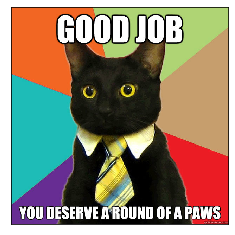

In [10]:
# Do not modify ANYTHING in this cell
# create random array
x = randn(100,200)

# verify that gradh_fft = gradh
h_error = norm(gradh_fft(x)-gradh(x))
print('Horizontal error = ', h_error)
assert h_error<1e-10, 'Horizontal FFT gradient is incorrect!'

# verify that gradv_fft = gradv
v_error = norm(gradv_fft(x)-gradv(x))
print('Vertical error = ',v_error)
assert v_error<1e-10, 'Vertical FFT gradient is incorrect!'

print("Tests PASSED!  Wow - you're a linear algebra GENIUS!")

f = urllib.request.urlopen("https://www.cs.umd.edu/~tomg/img/important_memes/good_job_cat.png")
a = plt.imread(f)
fig = plt.imshow(a)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()